# TD5 : SBM and its extensions

In [1]:
import numpy as np
import scipy
import sparsebm
import torch
import numpy as np
import parametrization_cookbook.torch as pc
import matplotlib.pyplot as plt

## SBM function

In [2]:
def SBM(n_nodes = 10, n_classes = 3, prob_classes = None, alpha = None, self_loop = True):
    """Generate SBM"""
    if prob_classes is None:
        prob_classes = np.ones(shape=n_classes) / n_classes
    if alpha is None:
        alpha = np.ones(shape=(n_classes, n_classes)) / 10
        np.fill_diagonal(alpha, 0.9)
    # Create Z, class vector
    Z = np.random.choice([i for i in range(n_classes)], size=n_nodes, p=prob_classes)
    # Generate bernouilli law
    alpha_expanded = alpha[Z][:, Z]
    X = np.random.binomial(n=1, p=alpha_expanded)
    if not self_loop:
        np.fill_diagonal(X, 0)
    return Z, X

In [3]:
K = 4
n = 500
Z, X = SBM(n_nodes = n, n_classes=K)
X_tensor = torch.tensor(X, dtype=torch.float32)
Z_tensor = torch.tensor(Z, dtype=torch.int64)

## Model selection with ICL

In [4]:
def get_entropy_and_expectation_log_likelihood(X_tensor, param_gamma, param_pi, param_alpha, gamma_prime, pi_prime, alpha_prime):
    """Return the entropy and expectation log-likelihood from the unconstrained parameters"""
    gamma = param_gamma.reals1d_to_params(gamma_prime)
    pi = param_pi.reals1d_to_params(pi_prime)
    alpha = param_alpha.reals1d_to_params(alpha_prime)

    entropy = - torch.einsum("ik,ik->", gamma, torch.log(gamma))
    expectation_log_likelihood = (torch.einsum("ik,k->", gamma, torch.log(pi)) 
                                  + torch.einsum("ik,jl,ij,kl->", gamma, gamma, X_tensor, torch.log(alpha))
                                  + torch.einsum("ik,jl,ij,kl->", gamma, gamma, 1 - X_tensor, torch.log(1-alpha))) 
    return entropy, expectation_log_likelihood

def ICL(expectation, K, n):
    """Compute ICL"""
    return expectation - 0.5 * (K - 1) * np.log(n) - 0.5 * K**2 * np.log(n**2)

In [5]:
ICLs = []
for K in range(2, 10):
    ICLs_K = []
    for i in range(3):
        param_gamma = pc.VectorSimplex(dim = K-1, shape=(n, ))
        param_pi = pc.VectorSimplex(dim=K-1)
        param_alpha = pc.RealBounded01(shape=(K,K))

        gp = torch.randn(param_gamma.size).clone().detach().requires_grad_(True)
        pp = torch.randn(param_pi.size).clone().detach().requires_grad_(True)
        ap = torch.randn(param_alpha.size).clone().detach().requires_grad_(True)

        optim = torch.optim.Adam([gp, pp, ap], lr=0.1)
        
        for i in range(3000):
            optim.zero_grad()
            entropy, expectation_log_lik = get_entropy_and_expectation_log_likelihood(X_tensor, param_gamma, param_pi, param_alpha, gp, pp, ap)
            elbo = entropy + expectation_log_lik
            (-elbo).backward()
            optim.step()
        ICLs_K.append(ICL(expectation_log_lik.item(), K, n))
    ICLs.append(np.max(ICLs_K))
    print(f"K = {K}, ICL = {ICLs[-1]}")

K = 2, ICL = -130617.6219864429
K = 3, ICL = -128328.37264348422
K = 4, ICL = -103213.69314172238
K = 5, ICL = -104675.1694186574
K = 6, ICL = -82580.15303678926
K = 7, ICL = -82685.44087111796
K = 8, ICL = -103573.92354664349
K = 9, ICL = -82910.89793836589


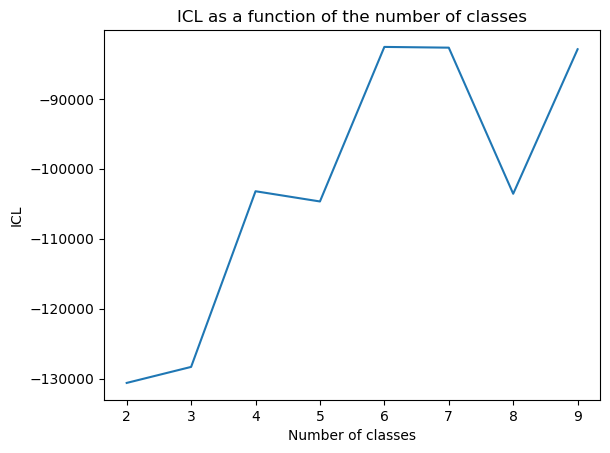

In [6]:
plt.plot(range(2, 10), ICLs)
plt.xlabel("Number of classes")
plt.ylabel("ICL")
plt.title("ICL as a function of the number of classes")
plt.show()

## On real dataset

In [7]:
import pandas as pd

In [8]:
edges = pd.read_csv('facebook_combined.txt', sep=' ', header=None).rename(columns={0: 'source', 1: 'target'})

In [9]:
adjacency_matrix = np.zeros((edges.values.max()+1, edges.values.max()+1))

for ligne in edges.iterrows():
    adjacency_matrix[ligne[1]['source'], ligne[1]['target']] = 1
    adjacency_matrix[ligne[1]['target'], ligne[1]['source']] = 1

adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)

In [10]:
def get_best_K(adjacency_matrix, K_begin = 2, K_end = 10, K_step = 1, n_iter = 5, max_optim_iter = 1000, lr = 0.1):
    ICLs = []
    for K in range(K_begin, K_end + 1, K_step):
        ICLs_K = []
        for i in range(n_iter):
            param_gamma = pc.VectorSimplex(dim = K-1, shape=(adjacency_matrix.shape[0], ))
            param_pi = pc.VectorSimplex(dim=K-1)
            param_alpha = pc.RealBounded01(shape=(K,K))

            gp = torch.randn(param_gamma.size).clone().detach().requires_grad_(True)
            pp = torch.randn(param_pi.size).clone().detach().requires_grad_(True)
            ap = torch.randn(param_alpha.size).clone().detach().requires_grad_(True)

            optim = torch.optim.Adam([gp, pp, ap], lr=lr)

            for i in range(max_optim_iter):
                optim.zero_grad()
                entropy, expectation_log_lik = get_entropy_and_expectation_log_likelihood(adjacency_matrix, param_gamma, param_pi, param_alpha, gp, pp, ap)
                elbo = entropy + expectation_log_lik
                (-elbo).backward()
                optim.step()
            ICLs_K.append(ICL(expectation_log_lik.item(), K, adjacency_matrix.shape[0]))
        ICLs.append(np.max(ICLs_K))
        print(f"K = {K}, ICL = {ICLs[-1]}")
    return np.argmax(ICLs) + 2, ICLs

In [12]:
K, ICLs = get_best_K(adjacency_matrix, K_begin = 2, K_end = 10, K_step = 2, n_iter = 5, max_optim_iter = 1000, lr = 0.1)

K = 2, ICL = -805512.11688587
K = 4, ICL = -732607.6906672724
K = 6, ICL = -699696.5694679993
K = 8, ICL = -650656.1907880505


KeyboardInterrupt: 

In [ ]:
plt.plot(range(2, 20, 2), ICLs)
plt.xlabel("Number of classes")
plt.ylabel("ICL")
plt.title("ICL as a function of the number of classes")
plt.show()